<a href="https://colab.research.google.com/github/mabrandes/hello-world/blob/main/01_basics_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Introduction: Deep Learning Basics
=====================

This tutorial is based on the *PyTorch 60 Minute Deep Learning Blitz* which I encourage you to check out if you want to learn more about PyTorch. 

In this tutorial, we will cover some practical aspects of training neural networks. 

Specifically, we will focus on the following learnings. 

- Chosing good optimization parameters is often more important than architectural decisions (width of layers, number of layers).
- Training on GPUs is very effective (if done right!).

The structure of the tutorial is as follows:

1. Going through the deep learning loop.
  1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
  2. Define a Convolutional Neural Network
  3. Define a loss function
  4. Train the network and test it

2. Studying the sensitivity of the training procedure with respect to...
  - Learning rate
  - Adaptive optimizers
  - Initialization
  - GPU training and speed.






1.1 Loading data
----------------------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

As a convenience, PyTorch also has data loaders for many common datasets in in vision, audio and text. (Check out the torchvision, torchaudio, torchtext packages.) This helps you avoid writing boilerplate code for the datasets and dataloaders and you can get started more quickly!

In this tutorial, we will use the CIFAR10 dataset. This is a vision dataset, with 3-channel color images of 32x32 pixels in size and ten classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. Our task will be to classify images correctly. 

CIFAR-10 has (PIL) images with RGB color values in the range [0, 255]. We transform those using the `ToTensor` (creates PyTorch Tensor and scales values to [0, 1]) and standardize over all pixels and all images for each color channel using empirical mean and standard deviation from the trainset using the `Normalize` transform. 


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())


Files already downloaded and verified


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 100
trainset_mean = torch.Tensor([0.4914, 0.4822, 0.4465])
trainset_std = torch.Tensor([0.2470, 0.2435, 0.2616])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(trainset_mean, trainset_std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

def get_loader(dataset, shuffle, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                          shuffle=shuffle, num_workers=2,
                                          pin_memory=True)

testloader = get_loader(testset, False, 1000)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



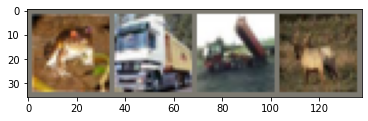

     frog     truck     truck      deer


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, mean, std):
    # img is C x W x H
    img = img * std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # PIL image is W x H x C
    plt.show()

# get some random training images
images, labels = zip(*[trainset[i] for i in range(4)])

# show images
imshow(torchvision.utils.make_grid(list(images)), trainset_mean, trainset_std)
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))


1.2 Defining the model - Convolutional Neural Network
---

In PyTorch, both networks and individual layers are implemented as subclasses of nn.Module. There are *many* layers available and you can easily compose new networks by combining them. 

For the purpose of this tutorial, we will compose a neural network using convolutional and fully connected layers. We also use max-pooling and RELU non-linearities. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def get_model(device):

  return SimpleNetwork().to(device)

# model = get_model('cpu')
# model.feature_extractor[0].weight
class SimpleNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=(2,2)),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=(2,2)),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.ReLU(),
          nn.Linear(64, 10)
        )
            

    def forward(self, x):
        bs = x.size(0)
        features = self.feature_extractor(x)
        features = features.view(bs, -1) # flatten
        logits = self.classifier(features)
        return logits

In [ ]:
model = get_model('cpu')

1.3 Defining Loss Function and Optimizer
---
We want to solve a classification problem and we use CrossEntropyLoss as our loss function. 
For now, we will just train with plain stochastic gradient descent. 

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

device = 'cpu'
model = model.to(device)

1.4 Train-Test-Loop
---
Let us set-up our train-test loops. 
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
import time

def experiment(num_epochs, trainloader, device, model, optimizer):
    train_results = {}
    test_results = {}
    # Initial test error
    loss, acc, time = test(device, model)
    print(f'Upon initialization. [Test] \t Time {time.avg:.2f} \
            Loss {loss.avg:.2f} \t Accuracy {acc.avg:.2f}')
    test_results[0] = (loss, acc, time)
    

    for epoch in range(1, num_epochs+1):
        loss, acc, time = train(trainloader, device, model, optimizer)
        print(f'Epoch {epoch}. [Train] \t Time {time.sum:.2f} Loss \
                {loss.avg:.2f} \t Accuracy {acc.avg:.2f}')
        train_results[epoch] = (loss.avg, acc.avg, time.avg)

        if not (epoch % 2):
          loss, acc, time = test(device, model)
          print(f'Epoch {epoch}. [Test] \t Time {time.sum:.2f} Loss \
                {loss.avg:.2f} \t Accuracy {acc.avg:.2f}')
          test_results[epoch] = (loss.avg, acc.avg, time.avg)

    return train_results, test_results

def train(trainloader, device, model, optimizer):
    time_ = AverageMeter()
    loss_ = AverageMeter()
    acc_ = AverageMeter()
    model.train()

    for i, data, in enumerate(trainloader, 1):
        # Accounting
        end = time.time()

        # get the inputs; data is a list of [inputs, labels]
        images, labels = data # bs x 3 x 32 x 32
        images = images.to(device)
        labels = labels.to(device)
        bs = images.size(0)
        # zero the parameter gradients
        optimizer.zero_grad()  # all the tensors have .grad attribute
        # forward propagation
        logits = model(images) # forward propagation 
        loss = criterion(logits, labels) # computing the loss for predictions
        # Backward propagation
        loss.backward() # backpropgation
        # Optimization step. 
        optimizer.step() # applying an optimization step

        # Accounting
        acc = (torch.argmax(logits, dim=-1) == labels).sum() / bs
        loss_.update(loss.mean().item(), bs)
        acc_.update(acc.item(), bs)
        time_.update(time.time() - end)
      
    return loss_, acc_, time_

def test(device, model):
    time_ = AverageMeter()
    loss_ = AverageMeter()
    acc_ = AverageMeter()
    model.eval()

    for i, data, in enumerate(testloader, 1):
        # Accounting
        end = time.time()
        
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        bs = images.size(0)

        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
            acc = (torch.argmax(logits, dim=-1) == labels).sum() / bs
    
            # Accounting
            loss_.update(loss.mean().item(), bs)
            acc_.update(acc.mean().item(), bs)
            time_.update(time.time() - end)

    return loss_, acc_, time_

class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

2 Running different experiments
=========


Baseline experiment (Experiment 0)
-----


In [ ]:
torch.manual_seed(10)
num_epochs = 10
batch_size = 100
trainloader = get_loader(trainset, True, batch_size=batch_size)
device = 'cpu'
model = get_model(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_res_0, test_res_0 = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 2.54             Loss 2.31 	 Accuracy 0.10


KeyboardInterrupt: ignored

Exploring the Effectiveness of GPUs (Experiment 1)
-----

In [ ]:
torch.manual_seed(10)
device = torch.device("cuda:0")
model_1 = get_model(device)
optimizer = optim.SGD(model_1.parameters(), lr=0.1)

train_res_1, test_res_1 = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model_1, 
                                 optimizer=optimizer)



Upon initialization. [Test] 	 Time 0.05             Loss 2.31 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 5.56 Loss                 2.03 	 Accuracy 0.24
Epoch 2. [Train] 	 Time 5.53 Loss                 1.57 	 Accuracy 0.42
Epoch 2. [Test] 	 Time 0.38 Loss                 1.43 	 Accuracy 0.49
Epoch 3. [Train] 	 Time 5.53 Loss                 1.30 	 Accuracy 0.53
Epoch 4. [Train] 	 Time 5.49 Loss                 1.09 	 Accuracy 0.61
Epoch 4. [Test] 	 Time 0.36 Loss                 1.13 	 Accuracy 0.60
Epoch 5. [Train] 	 Time 5.36 Loss                 0.90 	 Accuracy 0.69
Epoch 6. [Train] 	 Time 5.26 Loss                 0.76 	 Accuracy 0.73
Epoch 6. [Test] 	 Time 0.36 Loss                 0.83 	 Accuracy 0.71
Epoch 7. [Train] 	 Time 5.34 Loss                 0.68 	 Accuracy 0.76
Epoch 8. [Train] 	 Time 5.39 Loss                 0.58 	 Accuracy 0.80
Epoch 8. [Test] 	 Time 0.37 Loss                 0.81 	 Accuracy 0.73
Epoch 9. [Train] 	 Time 5.43 Loss                 0.51 	 Accuracy 0.83
Epo

In [ ]:
# Running with larger batch size. What will happens?
torch.manual_seed(10)
batch_size = 500
trainloader = get_loader(trainset, True, batch_size=batch_size)
model = get_model(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)

_ = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 0.04             Loss 2.31 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 4.42 Loss                 2.30 	 Accuracy 0.12
Epoch 2. [Train] 	 Time 4.44 Loss                 2.17 	 Accuracy 0.19
Epoch 2. [Test] 	 Time 0.37 Loss                 1.95 	 Accuracy 0.28
Epoch 3. [Train] 	 Time 4.49 Loss                 1.95 	 Accuracy 0.28
Epoch 4. [Train] 	 Time 4.50 Loss                 1.82 	 Accuracy 0.33
Epoch 4. [Test] 	 Time 0.36 Loss                 1.76 	 Accuracy 0.36
Epoch 5. [Train] 	 Time 4.54 Loss                 1.70 	 Accuracy 0.38
Epoch 6. [Train] 	 Time 4.51 Loss                 1.62 	 Accuracy 0.41
Epoch 6. [Test] 	 Time 0.37 Loss                 1.50 	 Accuracy 0.46
Epoch 7. [Train] 	 Time 4.51 Loss                 1.52 	 Accuracy 0.44
Epoch 8. [Train] 	 Time 4.48 Loss                 1.45 	 Accuracy 0.47
Epoch 8. [Test] 	 Time 0.37 Loss                 1.40 	 Accuracy 0.50
Epoch 9. [Train] 	 Time 4.52 Loss                 1.38 	 Accuracy 0.50
Epo

If the learning rate is too small... (Experiment 3)
---



In [ ]:
torch.manual_seed(10)
batch_size = 100
trainloader = get_loader(trainset, True, batch_size=batch_size)
model = get_model(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

_ = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 0.05             Loss 2.31 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 5.41 Loss                 2.30 	 Accuracy 0.12
Epoch 2. [Train] 	 Time 5.32 Loss                 2.30 	 Accuracy 0.14
Epoch 2. [Test] 	 Time 0.35 Loss                 2.29 	 Accuracy 0.15
Epoch 3. [Train] 	 Time 5.39 Loss                 2.22 	 Accuracy 0.17
Epoch 4. [Train] 	 Time 5.37 Loss                 1.93 	 Accuracy 0.28
Epoch 4. [Test] 	 Time 0.36 Loss                 1.85 	 Accuracy 0.31
Epoch 5. [Train] 	 Time 5.43 Loss                 1.77 	 Accuracy 0.34
Epoch 6. [Train] 	 Time 5.37 Loss                 1.65 	 Accuracy 0.39
Epoch 6. [Test] 	 Time 0.36 Loss                 1.58 	 Accuracy 0.41
Epoch 7. [Train] 	 Time 5.41 Loss                 1.57 	 Accuracy 0.42
Epoch 8. [Train] 	 Time 5.36 Loss                 1.50 	 Accuracy 0.45
Epoch 8. [Test] 	 Time 0.37 Loss                 1.47 	 Accuracy 0.46
Epoch 9. [Train] 	 Time 5.42 Loss                 1.43 	 Accuracy 0.48
Epo

If the learning rate is too large... (Experiment 4)
---


In [ ]:
torch.manual_seed(10)
model_4 = get_model(device)
optimizer = optim.SGD(model_4.parameters(), lr=1.0)

train_res, test_res = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model_4, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 0.04             Loss 2.31 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 5.38 Loss                 nan 	 Accuracy 0.11
Epoch 2. [Train] 	 Time 5.26 Loss                 nan 	 Accuracy 0.10
Epoch 2. [Test] 	 Time 0.36 Loss                 nan 	 Accuracy 0.10
Epoch 3. [Train] 	 Time 5.40 Loss                 nan 	 Accuracy 0.10
Epoch 4. [Train] 	 Time 5.30 Loss                 nan 	 Accuracy 0.10
Epoch 4. [Test] 	 Time 0.37 Loss                 nan 	 Accuracy 0.10
Epoch 5. [Train] 	 Time 5.30 Loss                 nan 	 Accuracy 0.10
Epoch 6. [Train] 	 Time 5.32 Loss                 nan 	 Accuracy 0.10
Epoch 6. [Test] 	 Time 0.37 Loss                 nan 	 Accuracy 0.10
Epoch 7. [Train] 	 Time 5.32 Loss                 nan 	 Accuracy 0.10
Epoch 8. [Train] 	 Time 5.35 Loss                 nan 	 Accuracy 0.10
Epoch 8. [Test] 	 Time 0.34 Loss                 nan 	 Accuracy 0.10
Epoch 9. [Train] 	 Time 5.33 Loss                 nan 	 Accuracy 0.10
Epoch 10. [Train

In [ ]:
def param_stats(model):
    print('\n')
    for name, param in model.named_parameters():
        absmax = param.abs().max()
        abssum = param.abs().sum()
        print(f'{name} with max abs {absmax.item():.2f} and sum abs {abssum:.2f}')

print('Bad model params.')
param_stats(model_4)
print('\n')
print('Good model params.')
param_stats(model_1)

Bad model params.


feature_extractor.0.weight with max abs nan and sum abs nan
feature_extractor.0.bias with max abs nan and sum abs nan
feature_extractor.3.weight with max abs nan and sum abs nan
feature_extractor.3.bias with max abs inf and sum abs inf
feature_extractor.6.weight with max abs nan and sum abs nan
feature_extractor.6.bias with max abs inf and sum abs inf
feature_extractor.9.weight with max abs nan and sum abs nan
feature_extractor.9.bias with max abs nan and sum abs nan
classifier.0.weight with max abs nan and sum abs nan
classifier.0.bias with max abs nan and sum abs nan
classifier.2.weight with max abs nan and sum abs nan
classifier.2.bias with max abs nan and sum abs nan
classifier.4.weight with max abs nan and sum abs nan
classifier.4.bias with max abs nan and sum abs nan


Good model params.


feature_extractor.0.weight with max abs 0.58 and sum abs 461.32
feature_extractor.0.bias with max abs 0.59 and sum abs 15.12
feature_extractor.3.weight with max abs 0.27 and

Using adaptive optimizers and regularization (Experiment 5)
---

In [ ]:
torch.manual_seed(10)
model = get_model(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

train_res, test_res = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 0.04             Loss 2.31 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 5.52 Loss                 2.00 	 Accuracy 0.24
Epoch 2. [Train] 	 Time 5.44 Loss                 1.44 	 Accuracy 0.47
Epoch 2. [Test] 	 Time 0.35 Loss                 1.30 	 Accuracy 0.52
Epoch 3. [Train] 	 Time 5.48 Loss                 1.15 	 Accuracy 0.58
Epoch 4. [Train] 	 Time 5.54 Loss                 0.95 	 Accuracy 0.66
Epoch 4. [Test] 	 Time 0.36 Loss                 0.89 	 Accuracy 0.69
Epoch 5. [Train] 	 Time 5.47 Loss                 0.80 	 Accuracy 0.72
Epoch 6. [Train] 	 Time 5.49 Loss                 0.69 	 Accuracy 0.76
Epoch 6. [Test] 	 Time 0.36 Loss                 0.77 	 Accuracy 0.74
Epoch 7. [Train] 	 Time 5.45 Loss                 0.60 	 Accuracy 0.79
Epoch 8. [Train] 	 Time 5.47 Loss                 0.53 	 Accuracy 0.81
Epoch 8. [Test] 	 Time 0.36 Loss                 0.69 	 Accuracy 0.77
Epoch 9. [Train] 	 Time 5.45 Loss                 0.47 	 Accuracy 0.84
Epo

In [ ]:
torch.manual_seed(10)
model = get_model(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

train_res, test_res = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 0.04             Loss 2.31 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 5.68 Loss                 1.64 	 Accuracy 0.39
Epoch 2. [Train] 	 Time 5.49 Loss                 1.20 	 Accuracy 0.56
Epoch 2. [Test] 	 Time 0.36 Loss                 1.06 	 Accuracy 0.62
Epoch 3. [Train] 	 Time 5.73 Loss                 0.97 	 Accuracy 0.65
Epoch 4. [Train] 	 Time 5.55 Loss                 0.83 	 Accuracy 0.71
Epoch 4. [Test] 	 Time 0.36 Loss                 0.88 	 Accuracy 0.69
Epoch 5. [Train] 	 Time 5.62 Loss                 0.72 	 Accuracy 0.75
Epoch 6. [Train] 	 Time 5.58 Loss                 0.66 	 Accuracy 0.77
Epoch 6. [Test] 	 Time 0.36 Loss                 0.76 	 Accuracy 0.74
Epoch 7. [Train] 	 Time 5.58 Loss                 0.59 	 Accuracy 0.79
Epoch 8. [Train] 	 Time 5.71 Loss                 0.55 	 Accuracy 0.81
Epoch 8. [Test] 	 Time 0.37 Loss                 0.77 	 Accuracy 0.74
Epoch 9. [Train] 	 Time 5.63 Loss                 0.51 	 Accuracy 0.82
Epo

Messing up initialization... (Experiment 6)
---

In [ ]:
def init_uniform(model):
  for param in model.parameters():
      param.data.uniform_()

torch.manual_seed(10)
model = get_model(device)
init_uniform(model)
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_res, test_res = experiment(num_epochs=num_epochs, 
                                 trainloader=trainloader, 
                                 device=device, 
                                 model=model, 
                                 optimizer=optimizer)

Upon initialization. [Test] 	 Time 0.04             Loss 202551697866752.00 	 Accuracy 0.10
Epoch 1. [Train] 	 Time 5.38 Loss                 890897899358513922048.00 	 Accuracy 0.10
Epoch 2. [Train] 	 Time 5.23 Loss                 2.31 	 Accuracy 0.10
Epoch 2. [Test] 	 Time 0.36 Loss                 2.31 	 Accuracy 0.10
Epoch 3. [Train] 	 Time 5.35 Loss                 2.30 	 Accuracy 0.10
Epoch 4. [Train] 	 Time 5.17 Loss                 2.30 	 Accuracy 0.10
Epoch 4. [Test] 	 Time 0.38 Loss                 2.30 	 Accuracy 0.10
Epoch 5. [Train] 	 Time 5.37 Loss                 2.30 	 Accuracy 0.10
Epoch 6. [Train] 	 Time 5.32 Loss                 2.30 	 Accuracy 0.10
Epoch 6. [Test] 	 Time 0.35 Loss                 2.30 	 Accuracy 0.10
Epoch 7. [Train] 	 Time 5.28 Loss                 2.30 	 Accuracy 0.10
Epoch 8. [Train] 	 Time 5.29 Loss                 2.30 	 Accuracy 0.10
Epoch 8. [Test] 	 Time 0.37 Loss                 2.30 	 Accuracy 0.10
Epoch 9. [Train] 	 Time 5.37 Loss       